<a href="https://colab.research.google.com/github/greek-nlp/benchmark/blob/main/nlp_gr_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation


### Load data and config

In [ ]:
%%capture
!pip install boto3
import boto3
from botocore.config import Config
from botocore.exceptions import ClientError

In [ ]:
from tqdm.notebook import tqdm
from google.colab import files
import os
import json
import random
import importlib
import pandas as pd

In [ ]:
print ('Upload the `aws.json` file: ')
files.upload()
credentials = json.load(open('aws.json'))

Upload the `aws.json` file: 


Saving aws.json to aws.json


### Set up the model

In [ ]:
# Initialize the boto3 client for Bedrock
bedrock_client = boto3.client(
    'bedrock',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'],
    region_name=credentials['aws_region']
)
bedrock_client.list_foundation_models()['modelSummaries']

In [ ]:
# Use the native inference API to send a text message to Meta Llama 3.
# Create a Bedrock Runtime client in the AWS Region of your choice.
client = boto3.client("bedrock-runtime",
                      aws_access_key_id=credentials['aws_access_key_id'],
                      aws_secret_access_key=credentials['aws_secret_access_key'],
                      region_name=credentials['aws_region'])

model_id = "meta.llama3-70b-instruct-v1:0"

In [ ]:
def llama_prompt(text,
                 instruction="Correct any grammatical errors in the following text but do not change the text otherwise, and return just the corrected text.",
                 shots="",
                 max_len=512,
                 model_id=model_id,
                 client=client):
  # Embed the prompt in Llama 3's instruction format.
  formatted_prompt = f"""
  <|begin_of_text|><|start_header_id|>user<|end_header_id|>
  {instruction}
  {shots}
  user: {text}
  <|eot_id|>
  <|start_header_id|>assistant<|end_header_id|>
  """

  # Format the request payload using the model's native structure.
  native_request = {
      "prompt": formatted_prompt,
      "max_gen_len": max_len,
      "temperature": 0.5,
  }

  # Convert the native request to JSON.
  request = json.dumps(native_request)

  try:
      # Invoke the model with the request.
      response = client.invoke_model(modelId=model_id, body=request)

  except (ClientError, Exception) as e:
      print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
      exit(1)

  # Decode the response body.
  model_response = json.loads(response["body"].read())

  # Extract and print the response text.
  response_text = model_response["generation"]
  return response_text

### Access the benchmark

In [ ]:
%%capture
!git clone https://github.com/greek-nlp/gen-a.git
!pip install zenodo-get
!pip install datasets
!pip install conll-df

import pandas as pd
import importlib

gr_data = pd.read_csv('gen-a/data.csv')
gena = importlib.import_module("gen-a.data_wrapper")

# GEC

In [ ]:
korre = gena.KorreDt(datasets=gr_data)
train = korre.get('train')

In [ ]:
texts = train.original_text.values
train['llama'] = [llama_prompt(t) for t in tqdm(texts)]

  0%|          | 0/175 [00:00<?, ?it/s]

In [ ]:
!pip install pywer
import pywer

wer = pywer.wer(train.original_text.values, train.llama.str.strip().values)
cer = pywer.cer(train.original_text.values, train.llama.str.strip().values)
print(f"WER: {wer:.2f}, CER: {cer:.2f}")

WER: 14.51, CER: 8.69


In [ ]:
train.sample().values[0]
train.to_csv('korre_llama3-70b-i_0s.csv')

In [ ]:
shots = """ Here are a couple of examples:
1.
user: Δεν ήθελε να θεωρηθεί προκατειλημένος και για αυτό δε συνέχισε τη συνεργασία περεταίρω.
assistant: Δεν ήθελε να θεωρηθεί προκατειλημμένος και για αυτό δε συνέχισε τη συνεργασία περαιτέρω.
2.
user: Το περιθώριο των κερδών τους δεν αλλάζουν εύκολα.
assistant: Το περιθώριο των κερδών τους δεν αλλάζει εύκολα.
"""
train['llama2s'] = [llama_prompt(t, shots) for t in tqdm(texts)]

  0%|          | 0/175 [00:00<?, ?it/s]

In [ ]:
wer = pywer.wer(train.original_text.values, train.llama2s.str.strip().values)
cer = pywer.cer(train.original_text.values, train.llama2s.str.strip().values)
print(f"WER: {wer:.2f}, CER: {cer:.2f}")

WER: 8.97, CER: 4.71


In [ ]:
train.to_csv('korre_llama3-70b-i.csv')

In [ ]:
train[train.original_text == train.corrected_text].shape

(0, 12)

# Toxicity

In [ ]:
zampieri = gena.ZampieriDt(datasets = gr_data)
zampieri_test = zampieri.get('test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0000.parquet:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/190k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8743 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1544 [00:00<?, ? examples/s]

In [ ]:
instruct = "You are a Greek moderator and you are given a text, return 1 if the text is offensive and 0 if not. Only the values 1 or 0 should be returned."
zampieri_test['llama'] = [llama_prompt(text=t, instruction=instruct, max_len=10) for t in tqdm(zampieri_test.text.values)]

  0%|          | 0/1544 [00:00<?, ?it/s]

In [ ]:
zampieri_test.llama.value_counts()[:5]

,count
llama,
0,1093
1,422
,22
0,2
I understand that you want me to check if the,1


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(zampieri_test.subtask_a, zampieri_test.llama.apply(lambda x: 1 if '1' in x else 0).values))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1302
           1       0.30      0.52      0.38       242

    accuracy                           0.73      1544
   macro avg       0.60      0.65      0.60      1544
weighted avg       0.80      0.73      0.76      1544



In [ ]:
zampieri_test.to_csv('toxicity.csv')

In [ ]:
shots = """ Here are a couple of labelled examples:
user: Πρέπει να πεθάνεις.
assistant: 1
user: Αυτή είναι μία ωραία εκπομπή.
assistant: 0
"""
zampieri_test['llama2s'] = [llama_prompt(text=t, instruction=instruct, shots=shots, max_len=10) for t in tqdm(zampieri_test.text.values)]

  0%|          | 0/1544 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(zampieri_test.subtask_a, zampieri_test.llama2s.apply(lambda x: 1 if x.strip()=='1' else 0).values))

              precision    recall  f1-score   support

           0       0.93      0.51      0.66      1302
           1       0.23      0.80      0.36       242

    accuracy                           0.55      1544
   macro avg       0.58      0.65      0.51      1544
weighted avg       0.82      0.55      0.61      1544



# MT

In [ ]:
prokopidis_mt = gena.ProkopidisMtDt(datasets=gr_data)
pd.set_option('display.max_colwidth', None)
for lang in prokopidis_mt.target_langs:
  print(f"Language: {lang} ({prokopidis_mt.langs_dict[lang]})")
  display(prokopidis_mt.get(lang, 'train').sample())

source: ell, target: eng
source: ell, target: jpn
source: ell, target: fas
Language: eng (English)


,source,target
26771,Η Shakila δεν αυτοκτόνησε.”,[Shakila did not commit suicide.”]


Language: jpn (Japanese)


,source,target
5488,"Αυτοί οι εθελοντές κατάφεραν να μοιραστούν φωτογραφίες, βίντεο και ιστορίες απ' όλα όσα είδαν στις επαρχίες Samar και Leyte.",[これらのボランティアたちは、自分たちがサマールおよびレイテで目撃した状況の写真、ビデオ、およびレポートを投稿することもできた。]


Language: fas (Farsi)


,source,target
1193,Δυναμώνουν τα τύμπανα του πολέμου για την Συρία,[طبل‌های جنگ علیه سوریه بلندتر نواخته می‌شوند]


In [ ]:
eng = prokopidis_mt.get('eng', 'test').copy()
jpn = prokopidis_mt.get('jpn', 'test').copy()
fas = prokopidis_mt.get('fas', 'test').copy()

#eng = pd.read_csv('eng_llama3_70b_i.csv')
#jpn = pd.read_csv('jpn_llama3_70b_i.csv')
#fas = pd.read_csv('fas_llama3_70b_i.csv')
#from ast import literal_eval
#eng.target = eng.target.apply(literal_eval)
#jpn.target = jpn.target.apply(literal_eval)
#fas.target = fas.target.apply(literal_eval)
#eng.llama.fillna('', inplace=True)
#jpn.llama.fillna('', inplace=True)
#fas.llama.fillna('', inplace=True)

<ipython-input-20-47324c695d83>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eng.llama.fillna('', inplace=True)
<ipython-input-20-47324c695d83>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method

In [ ]:
instruct = lambda source='ell', target='eng': f"Given a text in {source}, translate it to {target}. Only the translation should be returned."
eng['llama'] = [llama_prompt(text=t, instruction=instruct()) for t in tqdm(eng.source.values)]
jpn['llama'] = [llama_prompt(text=t, instruction=instruct(target='jpn')) for t in tqdm(jpn.source.values)]
fas['llama'] = [llama_prompt(text=t, instruction=instruct(target='fas')) for t in tqdm(fas.source.values)]


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
eng.to_csv('eng_llama3_70b_i.csv')
jpn.to_csv('jpn_llama3_70b_i.csv')
fas.to_csv('fas_llama3_70b_i.csv')

In [ ]:
!pip install pywer
import pywer

def ter(hyp, refs, unit='word'):
  """
  Compute the translation error rate between a hypothesis and a reference.
  If a list of references is provided, the minimum score is returned.
  :param hyp: The hypothesis.
  :param refs: The reference or list of references.
  :return: The TER score.
  """
  if isinstance(refs, str):
    refs = [refs]
  scores = [pywer.wer(refs, [hyp]) if unit=='word' else pywer.cer(refs, [hyp]) for ref in refs]
  return min(scores)

# Compute TER (word)
score = eng.apply(lambda row: ter(row.llama, row.target), axis=1)
print(f"Eng: {score.mean():.2f} ({score.std():.2f})")

score = jpn.apply(lambda row: ter(row.llama, row.target), axis=1)
print(f"Jpn: {score.mean():.2f} ({score.std():.2f})")

score = fas.apply(lambda row: ter(row.llama, row.target), axis=1)
print(f"Fas: {score.mean():.2f} ({score.std():.2f})")

Eng: 87.30 (372.76)
Jpn: 293.32 (597.64)
Fas: 91.11 (33.74)


In [ ]:
# Compute TER (char)
score = eng.apply(lambda row: ter(row.llama, row.target, 'char'), axis=1)
print(f"Eng: {score.mean():.2f} ({score.std():.2f})")

score = jpn.apply(lambda row: ter(row.llama, row.target, 'char'), axis=1)
print(f"Jpn: {score.mean():.2f} ({score.std():.2f})")

score = fas.apply(lambda row: ter(row.llama, row.target, 'char'), axis=1)
print(f"Fas: {score.mean():.2f} ({score.std():.2f})")

Eng: 55.60 (155.62)
Jpn: 148.93 (199.31)
Fas: 68.03 (28.82)


In [ ]:
# BERTscore
#!pip install evaluate bert_score
from evaluate import load
bertscore = load("bertscore")
results_en = [bertscore.compute(predictions=[p], references=[t[0]], lang="en") for p,t in tqdm(zip(eng.llama.values, eng.target.values))]

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
eng['bertscore_f1'] = [r['f1'][0] for r in results_en]
eng['bertscore_precision'] = [r['precision'][0] for r in results_en]
eng['bertscore_recall'] = [r['recall'][0] for r in results_en]
eng.bertscore_f1.mean()

0.9319197347164154

In [ ]:
results_ja = [bertscore.compute(predictions=[p], references=[t[0]], lang="ja") for p, t in tqdm(zip(jpn.llama.values, jpn.target.values))]

0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
jpn['bertscore_f1'] = [r['f1'][0] for r in results_ja]
jpn['bertscore_precision'] = [r['precision'][0] for r in results_ja]
jpn['bertscore_recall'] = [r['recall'][0] for r in results_ja]
jpn.bertscore_f1.mean()

0.604669093966484

In [ ]:
results_fa = [bertscore.compute(predictions=[p], references=[t[0]], lang="fa") for p, t in tqdm(zip(fas.llama.values, fas.target.values))]

0it [00:00, ?it/s]

In [ ]:
fas['bertscore_f1'] = [r['f1'][0] for r in results_fa]
fas['bertscore_precision'] = [r['precision'][0] for r in results_fa]
fas['bertscore_recall'] = [r['recall'][0] for r in results_fa]
fas.bertscore_f1.mean()

0.770234897851944

In [ ]:
eng.to_csv('eng_llama3_70b_i_bertscore.csv')
jpn.to_csv('jpn_llama3_70b_i_bertscore.csv')
fas.to_csv('fas_llama3_70b_i_bertscore.csv')

# Intent

In [ ]:
rizou = gena.RizouDt(datasets=gr_data).get('test')
rizou.sample()

,intent,text,ne_tags
1708,getTeacherInfoByTeacherName,στοιχεια επικοινωνιας καθηγητη κωστα τσιχλα,O O O O O


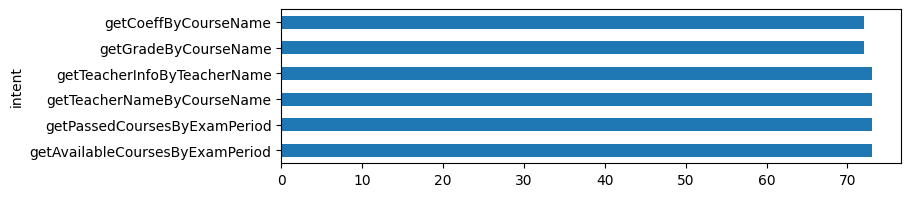

In [ ]:
classes = list(rizou.intent.unique())
rizou.intent.value_counts().plot.barh(figsize=(8,2));

In [ ]:
rizou.text.apply(len).describe()

,text
count,436.000000
mean,58.610092
std,30.295165
min,7.000000
25%,35.000000
50%,54.000000
75%,75.250000
max,174.000000


In [ ]:
instruct = "Given a text, provide the intent of the text. Only the intent should be returned. Here is the list of possible intents: " + ', '.join(classes)
rizou['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(rizou.text.values)]

  0%|          | 0/1740 [00:00<?, ?it/s]

In [ ]:
rizou.to_csv('rizou.csv')

In [ ]:
# fixing the values
rizou['llama_fixed'] = rizou.llama.apply(lambda x: x.strip() if str(x).strip() in classes else random.choice(classes))
rizou[rizou.llama.apply(lambda x: str(x).strip() not in classes)].shape

(18, 4)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(rizou.intent, rizou.llama_fixed))

                                 precision    recall  f1-score   support

getAvailableCoursesByExamPeriod       0.76      1.00      0.86       292
           getCoeffByCourseName       0.95      0.25      0.40       289
           getGradeByCourseName       0.83      0.92      0.87       290
   getPassedCoursesByExamPeriod       0.97      0.65      0.78       289
    getTeacherInfoByTeacherName       0.56      0.96      0.71       291
     getTeacherNameByCourseName       0.69      0.64      0.66       289

                       accuracy                           0.74      1740
                      macro avg       0.79      0.74      0.71      1740
                   weighted avg       0.79      0.74      0.71      1740



# Summarisation

In [ ]:
koniaris = gena.KoniarisDt(datasets = gr_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/153 [00:00<?, ?B/s]

hugginface_dataset.csv:   0%|          | 0.00/289M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8395 [00:00<?, ? examples/s]

subset
0    5888
1    1269
2    1238
Name: count, dtype: int64


In [ ]:
summ = koniaris.get('test')
summ.sample()

,text,summary,case_category,case_tags
1157,ΑΡΙΘΜΟΣ 626/2008 \n\n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟ...,Κατά της αποφάσεως που απορρίπτει την έφεση ως...,Αιτιολογίας επάρκεια,"Αγνώστου διαμονής επίδοση, Αιτιολογίας επάρκει..."


In [ ]:
summ.text.apply(len).describe()

,text
count,1238.000000
mean,18541.286753
std,18351.267169
min,2571.000000
25%,8320.250000
50%,13408.000000
75%,22558.500000
max,303538.000000


In [ ]:
summ.text.str.split().apply(len).describe()

,text
count,1238.000000
mean,2775.616317
std,2786.243851
min,381.000000
25%,1235.250000
50%,1988.000000
75%,3391.000000
max,46232.000000


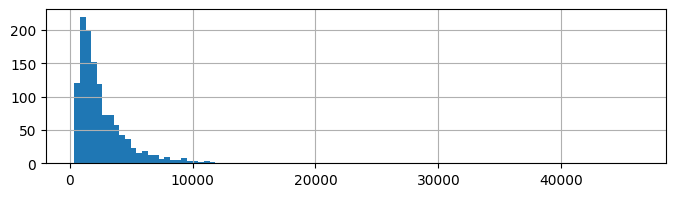

In [ ]:
summ.text.str.split().apply(len).hist(bins=100, figsize=(8,2));

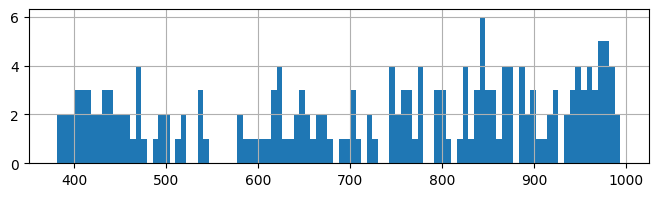

In [ ]:
summ_short = summ[summ.text.str.split().apply(len)<1000]
summ_short.text.str.split().apply(len).hist(bins=100, figsize=(8,2));

In [ ]:
summ_short.text.apply(len).describe()

,text
count,192.000000
mean,4898.994792
std,1318.943852
min,2571.000000
25%,3677.250000
50%,5148.500000
75%,5987.750000
max,6983.000000


In [ ]:
instruct = "Given a Greek legal text, provide its summary also in Greek. Only the summary should be returned."
summ_short['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(summ_short.text.values)]

  0%|          | 0/192 [00:00<?, ?it/s]

<ipython-input-61-d7719a476e49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(summ_short.text.values)]


In [ ]:
summ_short.sample()

,text,summary,case_category,case_tags,text_truncated,llama
300,ΑΡΙΘΜΟΣ 1784/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Απορρίπτει την αίτηση αναίρεσης ως ανυποστήρικ...,None,None,ΑΡΙΘΜΟΣ 1784/2011 ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓ...,Η Σύγκλητος απορρίπτει την αίτηση αναίρεσης τ...


In [ ]:
#!pip install evaluate bert_score
from evaluate import load
bertscore = load("bertscore")
bert_scores = [bertscore.compute(predictions=[p], references=[t[0]], lang="gr") for p,t in tqdm(zip(summ_short.llama.values, summ_short.summary.values))]

0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
summ_short['bert_f1'] = [r['f1'][0] for r in bert_scores]
summ_short['bert_precision'] = [r['precision'][0] for r in bert_scores]
summ_short['bert_recall'] = [r['recall'][0] for r in bert_scores]
summ_short.bert_f1.mean()

<ipython-input-67-25d2b3a36549>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['bert_f1'] = [r['f1'][0] for r in bert_scores]
<ipython-input-67-25d2b3a36549>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['bert_precision'] = [r['precision'][0] for r in bert_scores]
<ipython-input-67-25d2b3a36549>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

0.5191202739564081

In [ ]:
!pip install rouge
from rouge import Rouge
rouge = Rouge()
rouge_scores = [rouge.get_scores(p, t) for p,t in tqdm(zip(summ_short.llama.values, summ_short.summary.values))]

0it [00:00, ?it/s]

In [ ]:
rouge_scores[0][0]

{'rouge-1': {'r': 0.6190476190476191,
  'p': 0.3611111111111111,
  'f': 0.45614034622345334},
 'rouge-2': {'r': 0.36363636363636365,
  'p': 0.19047619047619047,
  'f': 0.2499999954882813},
 'rouge-l': {'r': 0.6190476190476191,
  'p': 0.3611111111111111,
  'f': 0.45614034622345334}}

In [ ]:
summ_short['rouge1_f1'] = [r[0]['rouge-1']['f'] for r in rouge_scores]
summ_short['rouge1_precision'] = [r[0]['rouge-1']['p'] for r in rouge_scores]
summ_short['rouge1_recall'] = [r[0]['rouge-1']['r'] for r in rouge_scores]

<ipython-input-77-c7a454d93708>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge1_f1'] = [r[0]['rouge-1']['f'] for r in rouge_scores]
<ipython-input-77-c7a454d93708>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge1_precision'] = [r[0]['rouge-1']['p'] for r in rouge_scores]
<ipython-input-77-c7a454d93708>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
summ_short['rouge2_f1'] = [r[0]['rouge-2']['f'] for r in rouge_scores]
summ_short['rouge2_precision'] = [r[0]['rouge-2']['p'] for r in rouge_scores]
summ_short['rouge2_recall'] = [r[0]['rouge-2']['r'] for r in rouge_scores]

<ipython-input-78-710a2869d734>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge2_f1'] = [r[0]['rouge-2']['f'] for r in rouge_scores]
<ipython-input-78-710a2869d734>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rouge2_precision'] = [r[0]['rouge-2']['p'] for r in rouge_scores]
<ipython-input-78-710a2869d734>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
summ_short['rougel_f1'] = [r[0]['rouge-l']['f'] for r in rouge_scores]
summ_short['rougel_precision'] = [r[0]['rouge-l']['p'] for r in rouge_scores]
summ_short['rougel_recall'] = [r[0]['rouge-l']['r'] for r in rouge_scores]

<ipython-input-79-040a2d5028b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rougel_f1'] = [r[0]['rouge-l']['f'] for r in rouge_scores]
<ipython-input-79-040a2d5028b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summ_short['rougel_precision'] = [r[0]['rouge-l']['p'] for r in rouge_scores]
<ipython-input-79-040a2d5028b0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [ ]:
summ_short.to_csv('summ_koniaris.csv')
summ_short[summ_short.columns[6:]].agg(['mean', 'std', 'sem'])

,bert_f1,bert_precision,bert_recall,rouge1_f1,rouge1_precision,rouge1_recall,rouge2_f1,rouge2_precision,rouge2_recall,rougel_f1,rougel_precision,rougel_recall
mean,0.519120,0.442687,0.628885,0.190842,0.180821,0.251943,0.047968,0.044959,0.070618,0.165556,0.155057,0.223851
std,0.103436,0.089444,0.126329,0.093245,0.108275,0.136189,0.061540,0.057158,0.107665,0.084400,0.093734,0.135008
sem,0.007465,0.006455,0.009117,0.006729,0.007814,0.009829,0.004441,0.004125,0.007770,0.006091,0.006765,0.009743


# Language modeling

In [ ]:
%%capture
!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM

In [ ]:
raw_datasets = {'dritsa21':gena.DritsaDt(datasets=gr_data).get('train'),
                'barzokas20':gena.BarzokasDt(datasets=gr_data).get('train'),
                'prokopidis20':gena.ProkopidisCrawledDt(datasets=gr_data).get('train'),
                'papantoniou23': gena.PapantoniouDt(datasets=gr_data).get('train')}

train_sets = {}
test_sets = {}
for dataset_name in raw_datasets:
  print(dataset_name)
  dataset = raw_datasets[dataset_name]
  dataset = dataset[dataset.text.notna()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  train_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[:1000] # lower lim
  test_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[1000:1500]

Title: A Greek Parliament Proceedings Dataset for Computational Linguistics and Political Analysis
Keywords: 
Publication date: 2022-06-09
DOI: 10.5281/zenodo.7005201
Total size: 1.4 GB

Link: https://zenodo.org/records/7005201/files/Greek Parliament Proceedings Dataset_Support Files_Word Usage Change Computations.zip   size: 1.4 GB

Checksum is correct. (81b2db432707334f85bd6feb44caac79)
All files have been downloaded.


Download github items in directory: /content/repo_56
Successfully downloaded data/corpora


Title: Dataset for Named Entity Recognition and Entity Linking from Greek Wikipedia Events
Keywords: Named Entity Recognition, Named Entity Linking, Benchmarking
Publication date: 2022-12-12
DOI: 10.5281/zenodo.7429037
Total size: 2.9 MB

Link: https://zenodo.org/records/7429037/files/ner_nel_greek_dataset.zip   size: 2.9 MB

Checksum is correct. (4dd6186f149be5b5a76336c28b88c1f1)
All files have been downloaded.


dritsa21
barzokas20
prokopidis20
papantoniou23


In [ ]:
ppls, ppls_std = {}, {}
for dname in raw_datasets:
  train = train_sets[dname]
  test = test_sets[dname]
  lm = LM(gram="CHAR")
  lm.train(' '.join(train.values)[:65000]) # length of min dataset
  ppls[dname], ppls_std[dname] = {}, {}
  for dname2 in raw_datasets:
    scores = test_sets[dname2].apply(lm.cross_entropy)
    ppls[dname][dname2] = scores.mean()
    ppls_std[dname][dname2] = scores.std()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


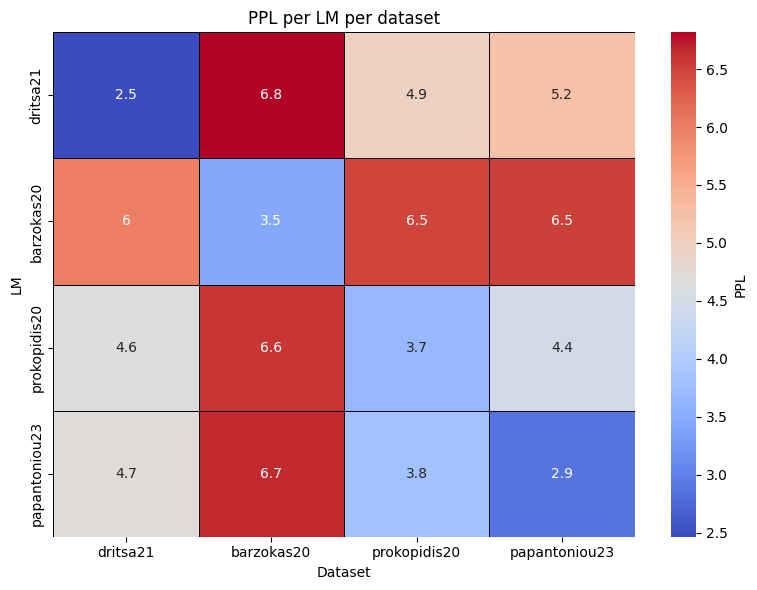

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ppls_pd = pd.DataFrame(ppls)
plt.figure(figsize=(8, 6))
sns.heatmap(ppls_pd, annot=True, cmap='coolwarm', linewidths=0.5,
            linecolor='black', cbar_kws={'label': 'PPL'});

# Add labels and a title
plt.title('PPL per LM per dataset'); plt.xlabel('Dataset'); plt.ylabel('LM');
plt.tight_layout();
plt.savefig('ppl_heatmap.pdf', dpi=300, format='PDF')

# Clustering

In [ ]:
#@title Clustering Accuracy
import numpy as np
from scipy.optimize import linear_sum_assignment as hungarian

def hungarian_acc(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = hungarian(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

In [ ]:
%%capture
papaloukas = gena.PapaloukasDt(datasets=gr_data).get('test')

In [ ]:
papaloukas.sample()

,text,volume,chapter,subject
1014,2. ΒΑΣΙΛΙΚΟΝ ΔΙΑΤΑΓΜΑ της 14/27 Νοεμ. 1951 Περ...,40,32,275


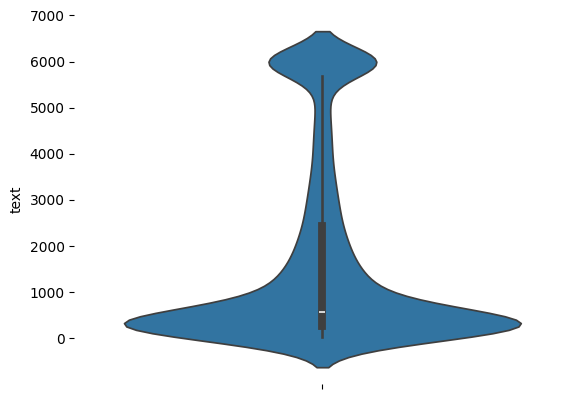

In [ ]:
import seaborn as sns
sns.violinplot(papaloukas.text.apply(lambda x: min(len(x), 6000)));
sns.despine(left=True, bottom=True);

## TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Convert the text documents to a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(papaloukas.text.values)
tfidf_matrix_dense = tfidf_matrix.toarray()

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (9516, 136515)


In [ ]:
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

test = papaloukas
# kmeans for k equal to number of labels (volumes, chapters, subjects)
for num_clusters in (47, 374, 1685):
  print(f"K={num_clusters}")
  km = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
  km.fit(tfidf_matrix)
  test[f'kmeans{num_clusters}'] = km.labels_
  print(f"NMI: {nmi(test.volume.values, km.labels_):.4f}")
  print(f"AMI: {ami(test.volume.values, km.labels_):.4f}")
  print(f"ACC: {hungarian_acc(test.volume.values, km.labels_):.4f}")
  print()

K=47
NMI: 0.1614
AMI: 0.1327
ACC: 0.1236

K=374
NMI: 0.3272
AMI: 0.1983
ACC: 0.0822

K=1685
NMI: 0.4586
AMI: 0.2059
ACC: 0.0566



In [ ]:
ground_truth = {47: 'volume', 374:'chapter', 1685:'subject'}
for num_clusters in ground_truth:
  print(f"K={num_clusters}")
  print(f"NMI: {nmi(test[ground_truth[num_clusters]].values, test[f'kmeans{num_clusters}']):.4f}")
  print(f"AMI: {ami(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print(f"ACC: {hungarian_acc(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print()

K=47
NMI: 0.1614
AMI: 0.1327
ACC: 0.1236

K=374
NMI: 0.4788
AMI: 0.1938
ACC: 0.1603

K=1685
NMI: 0.7267
AMI: 0.2019
ACC: 0.2641



## Instructor
* Texts have a length that is up to 6k characters
* Instructor's tokeniser has a limit of 512 tokens
* Texts are also in Greek (Instructor is not multilingual)

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

model = SentenceTransformer('hkunlp/instructor-large') # Using a sentence-transformer model
instruction = "Instruction: Compute representations for text clustering"
papaloukas['instructor'] = [model.encode(f"{instruction}: {t}") for t in tqdm(papaloukas.text.values)]
papaloukas.to_pickle('papaloukas-instructor.pkl')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

  0%|          | 0/9516 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
# upload the saved dataframe including the Instructor embeddings
papaloukas = pd.read_pickle('papaloukas-instructor.pkl')

,text,volume,chapter,subject,instructor
0,Όργανα που αποφασίζουν ή γνωμοδοτούν και ειδικ...,24,384,1722,"[0.015952576, -0.010978678, -0.0047769737, 0.0..."
1,12. ΑΝΑΓΚ. ΝΟΜΟΣ υπ’ αριθ. 1938 της 30 Αυγ./2 ...,35,292,1211,"[0.017706735, -0.012233494, 0.0025494162, 0.02..."
2,55. ΑΠΟΦΑΣΗ ΠΡΩΘΥΠΟΥΡΓΟΥ Αριθ. 300 της 24/29 Ι...,46,134,1787,"[0.015048083, -0.014629198, -0.0036612994, 0.0..."
3,2. ΝΟΜΟΣ 3743 της 4/9 Ιαν. 1929 Περί των εις τ...,11,48,57,"[0.019423362, -0.016431998, -0.0047592856, 0.0..."
4,27. ΑΠΟΦΑΣΙΣ ΥΠΟΥΡΓΟΥ ΕΘΝΙΚΗΣ ΠΑΙΔΕΙΑΣ ΚΑΙ ΘΡΗ...,44,161,2026,"[0.0030499392, -0.004164645, -0.00463799, 0.02..."
...,...,...,...,...,...
9511,Κύρωση του Ισολογισμού του Κράτους οικονομικού...,22,127,331,"[0.004726673, -0.010017517, -0.006469586, 0.01..."
9512,179. ΑΠΟΦΑΣΗ ΥΠΟΥΡΓΟΥ ΟΙΚΟΝΟΜΙΑΣ ΚΑΙ ΟΙΚΟΝΟΜΙΚ...,36,360,2208,"[-0.001476882, -0.007825648, -0.004659951, 0.0..."
9513,165. ΠΡΟΕΔΡΙΚΟ ΔΙΑΤΑΓΜΑ υπ’ αριθ. 507 της 10...,17,20,676,"[0.014795204, -0.0037231762, -0.006717046, 0.0..."
9514,8. ΝΟΜΟΣ υπ' αριθ. 836 της 21/28 Οκτ. 1943 Περ...,20,246,389,"[0.016263189, -0.0047879377, -0.009311615, 0.0..."


* Run KMeans on top of the Instructor embeddings
* Limitation: Instructor is not multilingual by default

In [ ]:
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


test = papaloukas
embeddings = normalize(np.array(papaloukas.instructor.tolist()))

# kmeans for k equal to number of labels (volumes, chapters, subjects)
for num_clusters in (47, 374, 1685):
  print(f"K={num_clusters}")
  km = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
  km.fit(embeddings)
  test[f'kmeans{num_clusters}'] = km.labels_
  print(f"NMI: {nmi(test.volume.values, km.labels_):.4f}")
  print(f"AMI: {ami(test.volume.values, km.labels_):.4f}")
  print(f"ARI: {ari(test.volume.values, km.labels_):.4f}")
  print()

ground_truth = {47: 'volume', 374:'chapter', 1685:'subject'}
for num_clusters in ground_truth:
  print(f"K={num_clusters}")
  print(f"NMI: {nmi(test[ground_truth[num_clusters]].values, test[f'kmeans{num_clusters}']):.4f}")
  print(f"AMI: {ami(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print(f"ARI: {ari(test[ground_truth[num_clusters]], test[f'kmeans{num_clusters}']):.4f}")
  print()

K=47
NMI: 0.0650
AMI: 0.0334
ARI: 0.0064

K=374
NMI: 0.1991
AMI: 0.0419
ARI: 0.0038

K=1685
NMI: 0.3474
AMI: 0.0376
ARI: 0.0022

K=47
NMI: 0.0650
AMI: 0.0334
ARI: 0.0064

K=374
NMI: 0.4110
AMI: 0.0441
ARI: 0.0077

K=1685
NMI: 0.6860
AMI: 0.0296
ARI: 0.0069



## Summarise+Translate+Embed (STE)

In [ ]:
instruction = '''Given a legal text in Greek, summarise and translate it to English.
Limit your response to 200 tokens; out directly the English translation; return no other text (e.g., do not start with "Here is the English translation").
'''
t = papaloukas.text.iloc[0]
print(t, '\n', llama_prompt(text=t[:6000], instruction=instruction, max_len=200))

Όργανα που αποφασίζουν ή γνωμοδοτούν και ειδικές ρυθμίσεις σε θέματα έργων που εκτελούνται από τον ΟΡΓΑΝΙΣΜΟ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ.Αρμόδια Όργανα Αρμόδιοι για τη λήψη αποφάσεων κατά τις διατάξεις του Ν. 1418/1984 «Δημόσια έργα και ρυθμίσεις συναφών θεμάτων», όπως τροποποιήθηκε με το Ν. 2229/1994 και των Προεδρικών Διαταγμάτων, τα οποία εκδίδονται σε εκτέλεση του, για τα έργα που εκτελούνται από τον ΟΡΓΑΝΙΣΜΟ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ (Ο.Α.Σ.Α.), είναι το Διοικητικό Συμβούλιο, ο Πρόεδρος του Διοικητικού Συμβουλίου και Γενικός Διευθυντής και τα εξουσιοδοτημένα όργανα, σύμφωνα με τις εκάστοτε ισχύουσες οργανωτικές διατάξεις του Ο.Α.Σ.Α. όπως ειδικότερα ορίζεται στα επόμενα άρθρα. Προκειμένου περί έργων που εκτελεί ο ΟΡΓΑΝΙΣΜΟΣ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ (Ο.Α.Σ.Α.):. Εργοδότης ή «Κύριος του έργου» είναι ο ΟΡΓΑΝΙΣΜΟΣ ΑΣΤΙΚΩΝ ΣΥΓΚΟΙΝΩΝΙΩΝ ΑΘΗΝΩΝ (Ο.Α.Σ.Α.). «Διευθύνουσα Υπηρεσία» ή «Επιβλέπουσα Υπηρεσία» είναι η υπηρεσία του Ο.Α.Σ.Α. που είναι αρμόδια, σύμφωνα με τις εκάστοτε ισχύου

In [ ]:
def sum_translate(text, max_out_len=200, max_in_len=2000):
  instruction = f'Given a legal text in Greek, summarise and translate it to English. Limit your response to {max_out_len} tokens; out directly the English translation; return no other text (e.g., do not start with "Here is the English translation").'
  try:
    return llama_prompt(text=text[:max_in_len], instruction=instruction, max_len=max_out_len)
  except:
    print(f'\nERROR\nTEXT: {text}\n')
    return None

papaloukas['llama_en_sum'] = [sum_translate(t) for t in tqdm(papaloukas.text.values)]

  0%|          | 0/9516 [00:00<?, ?it/s]

ERROR: Can't invoke 'meta.llama3-70b-instruct-v1:0'. Reason: An error occurred (ModelErrorException) when calling the InvokeModel operation: The system encountered an unexpected error during processing. Try your request again.

ERROR
TEXT: 2. ΝΟΜΟΘΕΤ. ΔΙΑΤΑΓΜΑ της 21 Νοεμ./3 Δεκ. 1925 Περί κωδικοποιήσεως των ν. 1954, 2635 και του από 23/26 Σεπτ. 1925 Ν.Δ. περί τροποποιήσεως των ν. 1954 και 2635 περί δανείων επί ενεχύρω καπνού Νέων Χωρών. Καταργήθηκε από την περίπτ. δ΄ παρ. 1 άρθρ. 20 Νομ. 2844/9-12 Οκτ. 2000, (ΦΕΚ Α΄220) κατωτ. αριθ. 3. 

ERROR: Can't invoke 'meta.llama3-70b-instruct-v1:0'. Reason: An error occurred (ModelErrorException) when calling the InvokeModel operation: The system encountered an unexpected error during processing. Try your request again.

ERROR
TEXT: 111. ΑΠΟΦΑΣΗ ΥΠΟΥΡΓΟΥ ΔΙΚΑΙΟΣΥΝΗΣ Αριθ. 93355 της 1/24 Νοεμ. 1982 (ΦΕΚ Β΄ 957) Στοιχεία που θα πρέπει να περιέχουν οι αιτήσεις που υποβάλλονται στους Δικηγορικούς Συλλόγους κατά τις διατάξεις του Νόμ. 1273/1982 για 

In [ ]:
from google.colab import files
f = 'papaloukas_sum_translate.csv'
papaloukas.to_csv(f)
files.download(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
papaloukas = pd.read_csv('papaloukas_sum_translate.csv', index_col=0)
papaloukas.sample()

* TFIDF of English summaries

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

# tackling empty values
papaloukas['llama_en_sum'] = papaloukas['llama_en_sum'].fillna('')

# Convert the text documents to a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(papaloukas.llama_en_sum.values)
tfidf_matrix_dense = tfidf_matrix.toarray()

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

test = papaloukas

# kmeans for k equal to number of labels (volumes, chapters, subjects)
for K, level in ((47,'volume'), (374,'chapter'), (1685,'subject')):
  print(f"K={K}")
  km = KMeans(n_clusters=K, random_state=42, n_init='auto')
  km.fit(tfidf_matrix)
  test[f'kmeans{K}'] = km.labels_
  print(f"NMI: {nmi(test[level].values, km.labels_):.4f}")
  print(f"AMI: {ami(test[level].values, km.labels_):.4f}")
  print(f"ACC: {hungarian_acc(test[ground_truth[K]], test[f'kmeans{K}']):.4f}")
  print()

TF-IDF matrix shape: (9516, 20480)
K=47
NMI: 0.1364
AMI: 0.1210
ACC: 0.1293

K=374
NMI: 0.3212
AMI: 0.1575
ACC: 0.1175

K=1685
NMI: 0.5101
AMI: 0.1114
ACC: 0.1624



In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

model = SentenceTransformer('hkunlp/instructor-large') # Using a sentence-transformer model
instruction = "Compute an embedding for this English legal text for clustering: "
papaloukas['ste'] = [model.encode(f"{instruction}: {t}") for t in tqdm(papaloukas.llama_en_sum.values)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

  0%|          | 0/9516 [00:00<?, ?it/s]

In [ ]:
papaloukas.to_pickle('papaloukas_sum_translate_embed.pkl', protocol=4)
from google.colab import files
files.download('papaloukas_sum_translate_embed.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
papaloukas = pd.read_pickle('papaloukas_sum_translate_embed.pkl')

In [ ]:
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

test = papaloukas
embeddings = np.vstack(test.ste.values)

for K, level in ((47,'volume'), (374,'chapter'), (1685,'subject')):
  print(f"K={K}")
  km = KMeans(n_clusters=K, random_state=42, n_init='auto')
  km.fit(embeddings)
  test[f'kmeans{K}'] = km.labels_
  print(f"NMI: {nmi(test[level].values, km.labels_):.4f}")
  print(f"AMI: {ami(test[level].values, km.labels_):.4f}")
  print(f"ACC: {hungarian_acc(test[ground_truth[K]], test[f'kmeans{K}']):.4f}")
  print()

K=47
NMI: 0.2441
AMI: 0.2188
ACC: 0.1943

K=374
NMI: 0.5240
AMI: 0.2252
ACC: 0.1747

K=1685
NMI: 0.7246
AMI: 0.1620
ACC: 0.2456



# Structure prediction (POS, NER)

## NER

In [ ]:
barziokas = gena.BarziokasDt(datasets=gr_data).get('test')
barziokas.sample()

Download github items in directory: /content/repo_285
Successfully downloaded dataset


,sentence,ne_tag4,ne_tag18
29,[naftemporiki.gr],[S-ORG],[S-ORG]


In [ ]:
# prompt: generate a prompt for llama for NER, using the following labels: ['S-LOC', 'O', 'B-ORG', 'E-ORG', 'B-PERSON', 'E-PERSON', 'I-ORG', 'B-LOC', 'E-LOC', 'S-PERSON', 'I-PERSON', 'S-ORG', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'I-LOC']. A sequence of labels should be returned and no other text. Add a few examples.

instruction = """You are a Greek NLP expert and you are given a text. Return a sequence of NER labels for each token in the text. The labels should be chosen from the following list: ['S-LOC', 'O', 'B-ORG', 'E-ORG', 'B-PERSON', 'E-PERSON', 'I-ORG', 'B-LOC', 'E-LOC', 'S-PERSON', 'I-PERSON', 'S-ORG', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'I-LOC']. Do not return any other text.
Here are a couple of labelled examples:

user: Η Αθήνα είναι η πρωτεύουσα της Ελλάδας.
assistant: B-LOC E-LOC O O O B-LOC E-LOC O

user: Ο Αλέξης Τσίπρας είναι πρωθυπουργός της Ελλάδας.
assistant: B-PERSON I-PERSON E-PERSON O O B-LOC E-LOC O
"""
barziokas['llama_demo'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(barziokas.sentence.values)]

  0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
barziokas.llama_demo

,llama_demo
1,B-LOC O B-LOC O O O O O O O O B-ORG O
2,B-MISC O O O O O O O O O B-PERSON E-PERSON O ...
3,O O O B-ORG E-ORG O O O O O O O O O B-ORG O
4,O O O O O O O O O O O O O O O O O O O
5,O: O\n πρωθυπουργός: B-PERSON\n Χάιντερ: ...
...,...
295,O O O O O B-ORG E-ORG O O O O O O O O O O O O...
296,S-MISC O B-LOC E-LOC O B-PERSON E-PERSON
297,"[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O..."
298,O O O O O O O O O O O O O O O O O O O O O O O...


In [ ]:
import ast
ner_labels = ['S-LOC', 'B-LOC', 'I-LOC', 'E-LOC', 'S-ORG', 'B-ORG', 'I-ORG', 'E-ORG', 'S-PERSON', 'B-PERSON', 'I-PERSON', 'E-PERSON', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'O']
def extract_list(text, labels = ner_labels):
  if isinstance(text, str):
    text = text.strip().replace('\n', '')
    if '[' in text and ']' in text:
      if ('"' not in text) and ("'" not in text):
        for label in labels:
          text = text.replace(label, f'"{label}"')
      text = text[text.index('[') : text.index(']')+1]
    else:
      text = text.split()
    try:
      text = ast.literal_eval(text)
    except:
      text = []
  return text

barziokas['llama_list'] = barziokas.llama_demo.fillna('[]').apply(extract_list)

In [ ]:
predictions = barziokas.apply(lambda row: row.llama_list[:len(row.ne_tag4)] + ['O' for _ in range(len(row.ne_tag4)-len(row.llama_list))], axis=1)
gold = barziokas.ne_tag4
from sklearn.metrics import classification_report
print(classification_report(gold.explode(), predictions.explode(), labels=ner_labels, zero_division=0))

### Original attempt

In [ ]:
instruction = '''
Identify and label named entities in a given sentence using the specified NER tag set: `['S-LOC', 'O', 'B-ORG', 'E-ORG', 'B-PERSON', 'E-PERSON', 'I-ORG', 'B-LOC', 'E-LOC', 'S-PERSON', 'I-PERSON', 'S-ORG', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'I-LOC']`.
You will be provided with a list of words, which form a sentence. Your task is to analyze this sentence and assign the appropriate named entity tag to each word.
- For single-token entities, use the `S-` prefix followed by the appropriate entity type (e.g., `S-LOC` for a single-token location).
- For multi-token entities, use the `B-`, `I-`, and `E-` prefixes to denote the beginning, inside, and end of the entity, respectively (e.g., `B-PERSON`, `I-PERSON`, `E-PERSON` for a person entity spanning multiple tokens).
- Use the `O` tag for words that are not part of any named entity.
Generate just a list with just the elements being the named entity tags corresponding to each word in the input list. Ensure that the tags correctly represent the boundaries and types of named entities as per the tag set provided.
No text should be provided other than the list.

Tag Set:
    - `S-LOC`: Single-token location entity.
    - `O`: Outside any named entity.
    - `B-ORG`: Beginning of an organization entity.
    - `E-ORG`: End of an organization entity.
    - `B-PERSON`: Beginning of a person entity.
    - `E-PERSON`: End of a person entity.
    - `I-ORG`: Inside an organization entity.
    - `B-LOC`: Beginning of a location entity.
    - `E-LOC`: End of a location entity.
    - `S-PERSON`: Single-token person entity.
    - `I-PERSON`: Inside a person entity.
    - `S-ORG`: Single-token organization entity.
    - `S-MISC`: Single-token miscellaneous entity.
    - `B-MISC`: Beginning of a miscellaneous entity.
    - `I-MISC`: Inside a miscellaneous entity.
    - `E-MISC`: End of a miscellaneous entity.
    - `I-LOC`: Inside a location entity.
'''
barziokas['llama'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(barziokas.sentence.values)]

  0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
barziokas.to_csv('barziokas.csv')
#barziokas = pd.read_csv('barziokas.csv')

In [ ]:
import ast
ner_labels = ['S-LOC', 'B-LOC', 'I-LOC', 'E-LOC', 'S-ORG', 'B-ORG', 'I-ORG', 'E-ORG', 'S-PERSON', 'B-PERSON', 'I-PERSON', 'E-PERSON', 'S-MISC', 'B-MISC', 'I-MISC', 'E-MISC', 'O']
def extract_list(text, labels = ner_labels):
  if isinstance(text, str):
    text = text.strip().replace('\n', '')
    if '[' in text and ']' in text:
      if ('"' not in text) and ("'" not in text):
        for label in labels:
          text = text.replace(label, f'"{label}"')
      text = text[text.index('[') : text.index(']')+1]
    else:
      text = '[]'
    try:
      text = ast.literal_eval(text)
    except:
      text = []
  return text

barziokas['llama_list'] = barziokas.llama.fillna('[]').apply(extract_list)

In [ ]:
predictions = barziokas.apply(lambda row: row.llama_list[:len(row.ne_tag4)] + ['O' for _ in range(len(row.ne_tag4)-len(row.llama_list))], axis=1)
gold = barziokas.ne_tag4

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(gold.explode(), predictions.explode(), labels=ner_labels, zero_division=0))

              precision    recall  f1-score   support

       S-LOC       0.20      0.06      0.09       177
       B-LOC       0.04      0.15      0.06        39
       I-LOC       0.02      0.09      0.03        11
       E-LOC       0.04      0.10      0.06        39
       S-ORG       0.23      0.10      0.14        69
       B-ORG       0.10      0.14      0.12        90
       I-ORG       0.09      0.11      0.10        46
       E-ORG       0.12      0.12      0.12        90
    S-PERSON       0.21      0.19      0.20        31
    B-PERSON       0.16      0.21      0.18        48
    I-PERSON       0.05      1.00      0.09         1
    E-PERSON       0.23      0.23      0.23        48
      S-MISC       0.00      0.00      0.00        16
      B-MISC       0.02      0.05      0.03        19
      I-MISC       0.02      0.04      0.03        28
      E-MISC       0.00      0.00      0.00        19
           O       0.94      0.90      0.92      8197

   micro avg       0.84   

## POS

In [ ]:
prokopidis_ud = gena.ProkopidisUdDt( datasets=gr_data)
prokopidis_ud.get('test').head()

Download github items in directory: /content/repo_438
Successfully downloaded el_gdt-ud-train.conllu
Successfully downloaded el_gdt-ud-dev.conllu
Successfully downloaded el_gdt-ud-test.conllu


w         l      x      p   g         f type Person Tense Foreign  \
s i                                                                            
1 1    Κύριε    κύριος   NOUN   NOUN   2      nmod    _      _     _       _   
  2  Πρόεδρε  πρόεδρος   NOUN   NOUN  13  vocative    _      _     _       _   
  3        ,         ,  PUNCT  PUNCT   2     punct    _      _     _       _   
  4       το         ο    DET    DET   5       det  Art      _     _       _   
  5   ζήτημα    ζήτημα   NOUN   NOUN  13     nsubj    _      _     _       _   

    Case Gender Definite Aspect Type Poss Voice Number Mood Degree  
s i                                                                 
1 1  Voc   Masc        _      _    _    _     _   Sing    _      _  
  2  Voc   Masc        _      _    _    _     _   Sing    _      _  
  3    _      _        _      _    _    _     _      _    _      _  
  4  Nom   Neut      Def      _  Art    _     _   Sing    _      _  
  5  Nom   Neut        _      _    _    _     _   Sing    _      _

In [ ]:
labels=prokopidis_ud.get('test').x.unique()
prokopidis_ud.get('test').x.value_counts()

,count
x,
NOUN,2304
DET,2016
PUNCT,1093
VERB,973
ADJ,883
ADP,864
AUX,505
ADV,448
PRON,367


In [ ]:
prokopidis_ud.get('test').shape

(10922, 20)

In [ ]:
prokopidis_ud.get('test').x.value_counts().iloc[-1]/prokopidis_ud.get('test').x.value_counts().iloc[0]

0.030381944444444444

In [ ]:
text_level_pos = pd.DataFrame()
text_level_pos['w'] = prokopidis_ud.get('test').groupby('s').w.apply(list)
text_level_pos['x'] = prokopidis_ud.get('test').groupby('s').x.apply(list)
text_level_pos.head()

,w,x
s,,
1,"[Κύριε, Πρόεδρε, ,, το, ζήτημα, του, ευρωπαϊκο...","[NOUN, NOUN, PUNCT, DET, NOUN, DET, ADJ, NOUN,..."
2,"[Να, σας, δώσω, καταρχάς, ένα, τυχαίο, παράδει...","[AUX, PRON, VERB, ADV, DET, ADJ, NOUN, DET, DE..."
3,"[Αυτό, είναι, σωστό, .]","[PRON, AUX, ADJ, PUNCT]"
4,"[Έτσι, ,, ένας, ολλανδός, γιατρός, ο, οποίος, ...","[ADV, PUNCT, DET, NOUN, NOUN, DET, PRON, VERB,..."
5,"[Μπορεί, όμως, αυτός, ο, γιατρός, να, πάει, κά...","[VERB, CCONJ, DET, DET, NOUN, AUX, VERB, ADV, ..."


In [ ]:
text_level_pos.w.apply(len).describe()

,w
count,456.000000
mean,23.951754
std,15.988247
min,1.000000
25%,12.000000
50%,21.000000
75%,32.250000
max,96.000000


In [ ]:
# prompt: generate a prompt for llama for POS tagging, defining the following categories: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'. The input will already be tokenised to assist keeping the same length. Provide an explanation per named entity and provide a few examples.

instruction = """You are a Greek NLP expert and you are given a text that has already been tokenised. Return a sequence of Part-of-speech (POS) tags for each token in the text.
The labels should be chosen from the following list: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'.
Do not return any other text.

**Explanation of POS Tags:**

* **NOUN:** Noun (e.g., "άνθρωπος", "πόλη")
* **DET:** Determiner (e.g., "ο", "η", "το")
* **PUNCT:** Punctuation (e.g., ".", ",", "!")
* **VERB:** Verb (e.g., "γράφω", "τρώω")
* **ADJ:** Adjective (e.g., "καλός", "μεγάλος")
* **ADP:** Adposition (prepositions and postpositions) (e.g., "σε", "με", "από")
* **AUX:** Auxiliary verb (e.g., "είμαι", "έχω")
* **ADV:** Adverb (e.g., "γρήγορα", "πολύ")
* **PRON:** Pronoun (e.g., "εγώ", "εσύ", "αυτός")
* **CCONJ:** Coordinating conjunction (e.g., "και", "ή")
* **PROPN:** Proper noun (e.g., "Αθήνα", "Γιώργος")
* **_:** Represents an unknown or missing tag.
* **SCONJ:** Subordinating conjunction (e.g., "ότι", "αν")
* **NUM:** Numeral (e.g., "ένα", "δύο")
* **X:** Other (e.g., foreign words, abbreviations)
* **PART:** Particle (e.g., "να", "μη")

**Examples:**

* **Input:** ["Ο", "Γιώργος", "γράφει", "ένα", "βιβλίο", "."]
* **Output:** ['DET', 'PROPN', 'VERB', 'DET', 'NOUN', 'PUNCT']

* **Input:** ["Η", "γρήγορη", "αλώπηκα", "τρέχει", "."]
* **Output:** ['DET', 'ADJ', 'NOUN', 'VERB', 'PUNCT']

"""

text_level_pos['llama'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(text_level_pos.w.values)]

In [ ]:
def extract_list(text, labels = labels):
  """
  Extract a list from a string.
  :param text: The string to extract the list from.
  :param labels: The list of labels to use.
  :return: The list extracted from the string.
  """
  text = text.strip().replace('"', '').replace('\n', '').replace("'", '')
  text = text.replace('.', '').replace(',', '')
  text = text.replace('[', '').replace(']', '')
  casted_list = text.split()
  if len(set(casted_list).intersection(set(labels)))==0:
    return []
  return casted_list

text_level_pos['llama_post'] = text_level_pos['llama'].apply(lambda x: extract_list(x, labels=labels))

In [ ]:
import numpy as np
predictions = text_level_pos.apply(lambda row: row.llama_post[:len(row.x)] + [np.random.choice(labels) for _ in range(len(row.x)-len(row.llama_post))], axis=1)
gold = text_level_pos.x
from sklearn.metrics import classification_report
print(classification_report(gold.explode(), predictions.explode(), labels=labels, zero_division=0))

              precision    recall  f1-score   support

        NOUN       0.63      0.52      0.57      2304
       PUNCT       0.55      0.56      0.55      1093
         DET       0.58      0.59      0.59      2016
         ADJ       0.58      0.48      0.53       883
         AUX       0.39      0.14      0.21       505
         ADV       0.47      0.41      0.44       448
        PART       0.00      0.01      0.01        70
       SCONJ       0.48      0.43      0.45       178
        VERB       0.51      0.65      0.57       973
       CCONJ       0.47      0.46      0.46       363
         ADP       0.38      0.44      0.41       864
        PRON       0.33      0.20      0.25       367
       PROPN       0.28      0.62      0.38       325
           _       0.01      0.00      0.01       250
           X       0.04      0.02      0.03       127
         NUM       0.33      0.61      0.43       156

   micro avg       0.49      0.49      0.49     10922
   macro avg       0.38   

In [ ]:
# prompt: generate a prompt for llama for POS tagging, defining the following categories: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'. The input will already be tokenised to assist keeping the same length. Provide an explanation per named entity and provide a few examples.

instruction = """You are a Greek NLP expert and you are given a text that has already been tokenised. Return a sequence of Part-of-speech (POS) tags for each token in the text.
The labels should be chosen from the following list: 'NOUN', 'DET', 'PUNCT', 'VERB', 'ADJ', 'ADP', 'AUX', 'ADV', 'PRON', 'CCONJ', 'PROPN', '_', 'SCONJ', 'NUM', 'X', 'PART'.
Do not return any other text.

**Explanation of POS Tags:**

* **NOUN:** Noun (e.g., "άνθρωπος", "πόλη")
* **DET:** Determiner (e.g., "ο", "η", "το")
* **PUNCT:** Punctuation (e.g., ".", ",", "!")
* **VERB:** Verb (e.g., "γράφω", "τρώω")
* **ADJ:** Adjective (e.g., "καλός", "μεγάλος")
* **ADP:** Adposition (prepositions and postpositions) (e.g., "σε", "με", "από")
* **AUX:** Auxiliary verb (e.g., "είμαι", "έχω")
* **ADV:** Adverb (e.g., "γρήγορα", "πολύ")
* **PRON:** Pronoun (e.g., "εγώ", "εσύ", "αυτός")
* **CCONJ:** Coordinating conjunction (e.g., "και", "ή")
* **PROPN:** Proper noun (e.g., "Αθήνα", "Γιώργος")
* **_:** Represents an unknown or missing tag.
* **SCONJ:** Subordinating conjunction (e.g., "ότι", "αν")
* **NUM:** Numeral (e.g., "ένα", "δύο")
* **X:** Other (e.g., foreign words, abbreviations)
* **PART:** Particle (e.g., "να", "μη")

"""

text_level_pos['llama0s'] = [llama_prompt(text=t, instruction=instruction) for t in tqdm(text_level_pos.w.values)]

  0%|          | 0/456 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
text_level_pos['llama_post'] = text_level_pos['llama0s'].apply(lambda x: extract_list(x, labels=labels))
predictions = text_level_pos.apply(lambda row: row.llama_post[:len(row.x)] + [np.random.choice(labels) for _ in range(len(row.x)-len(row.llama_post))], axis=1)
gold = text_level_pos.x
print(classification_report(gold.explode(), predictions.explode(), labels=labels, zero_division=0))

              precision    recall  f1-score   support

        NOUN       0.61      0.51      0.56      2304
       PUNCT       0.57      0.55      0.56      1093
         DET       0.61      0.59      0.60      2016
         ADJ       0.57      0.45      0.50       883
         AUX       0.36      0.14      0.20       505
         ADV       0.48      0.34      0.40       448
        PART       0.01      0.04      0.02        70
       SCONJ       0.50      0.45      0.47       178
        VERB       0.50      0.66      0.57       973
       CCONJ       0.49      0.48      0.48       363
         ADP       0.39      0.45      0.41       864
        PRON       0.34      0.20      0.26       367
       PROPN       0.26      0.63      0.37       325
           _       0.02      0.00      0.01       250
           X       0.05      0.03      0.04       127
         NUM       0.31      0.63      0.42       156

   micro avg       0.49      0.48      0.49     10922
   macro avg       0.38   

In [ ]:
print(classification_report(gold[:175].explode(), predictions[:175].explode(), labels=labels, zero_division=0))

              precision    recall  f1-score   support

        NOUN       0.64      0.52      0.57       721
       PUNCT       0.61      0.60      0.61       372
         DET       0.64      0.61      0.63       631
         ADJ       0.61      0.44      0.51       275
         AUX       0.34      0.15      0.21       154
         ADV       0.54      0.36      0.43       143
        PART       0.00      0.00      0.00        24
       SCONJ       0.51      0.37      0.43        57
        VERB       0.51      0.67      0.58       313
       CCONJ       0.52      0.57      0.55        95
         ADP       0.43      0.49      0.46       284
        PRON       0.46      0.27      0.34       109
       PROPN       0.29      0.64      0.40       128
           _       0.06      0.01      0.02        77
           X       0.00      0.00      0.00        62
         NUM       0.43      0.73      0.54        78

   micro avg       0.52      0.50      0.51      3523
   macro avg       0.41   

In [ ]:
text_level_pos.to_csv('pos-llama70b.csv')

# Authorship analysis
* Stdying whether LLMs encoded data from open books

In [ ]:
barzokas = gena.BarzokasDt(datasets=gr_data).get('train')
barzokas.sample()

Download github items in directory: /content/repo_56
Successfully downloaded data/corpora


,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,authorYearOfBirth,authorYearOfDeath,tokensCount,text,status,publisher
80,PG17995,Ηλέκτρα,Euripides,NaN,1910,NaN,NaN,NaN,NaN,0.0,-406.0,13239.0,Translation into modern Greek by Angelos Tanag...,malformed,project_gutenberg


In [ ]:
# removing duplicates
print(barzokas.shape[0])
print('Removing duplicates...')
barzokas.drop_duplicates(inplace=True, subset=['text'])
print(barzokas.shape[0])

2677
Removing duplicates...
1734


In [ ]:
barzokas_df = barzokas[barzokas.status=='parsable']
barzokas_df.shape

(1105, 15)

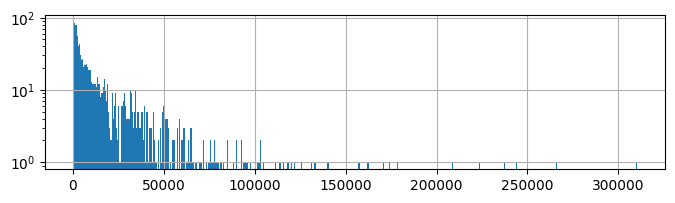

In [ ]:
# we need enough size to sample text from within
barzokas_df.tokensCount.hist(bins=500, figsize=(8,2), log=True);

In [ ]:
barzokas_df = barzokas_df[barzokas_df.tokensCount>1000]
barzokas_df.shape

(985, 15)

In [ ]:
# sampling 1000 characters from the middle of the text
def get_excerpt(text):
  mid = len(text)/2
  return text[int(mid-500):int(mid+500)]

barzokas_df['excerpt'] = barzokas_df.text.apply(get_excerpt)

<ipython-input-28-67eb2e66211b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_df['excerpt'] = barzokas_df.text.apply(get_excerpt)


In [ ]:
barzokas_df[['id', 'title', 'excerpt', 'author', 'type', 'publishedYear', 'tokensCount']].to_csv('barzokas_excerpt.csv', index=False)

(179, 16)


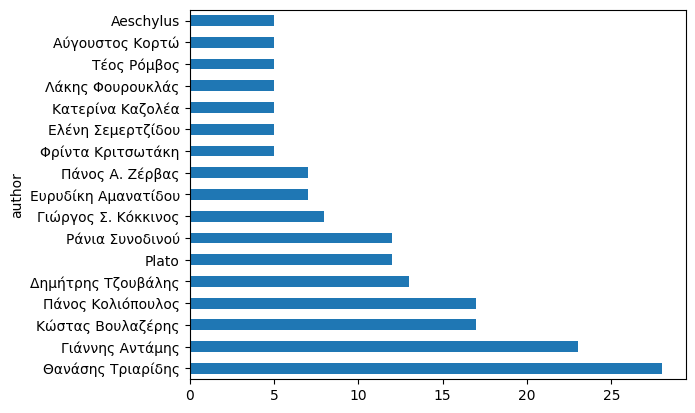

In [ ]:
pop_authors = barzokas_df.author.value_counts()[:17].index.tolist()
barzokas_pop = barzokas_df[barzokas_df.author.isin(pop_authors)]
print(barzokas_pop.shape)
barzokas_pop.author.value_counts().plot.barh();

In [ ]:
barzokas_pop.excerpt.apply(len).describe()

,excerpt
count,179.0
mean,1000.0
std,0.0
min,1000.0
25%,1000.0
50%,1000.0
75%,1000.0
max,1000.0


In [ ]:
barzokas_pop.author.value_counts().iloc[-1]/barzokas_pop.author.value_counts().iloc[0]

0.17857142857142858

In [ ]:
instruct = "Given an excerpt from a Greek book, return the author it is from by picking from the following authors: " + ', '.join(pop_authors) +' Return only the name of the author, nothing else.'
barzokas_pop['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(barzokas_pop.excerpt.values)]

  0%|          | 0/179 [00:00<?, ?it/s]

<ipython-input-50-fc029ae79c57>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop['llama'] = [llama_prompt(text=t, instruction=instruct) for t in tqdm(barzokas_pop.excerpt.values)]


In [ ]:
barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Θανάσης Τριαρίδης" if "ανάση" in x else x)
barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Plato" if "Plato" in x else x)
barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Κολιόπουλος" if "Κολιόπουλος" in x else x)

<ipython-input-51-d66ed2160233>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Θανάσης Τριαρίδης" if "ανάση" in x else x)
<ipython-input-51-d66ed2160233>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop['llama'] = barzokas_pop.llama.apply(lambda x: "Plato" if "Plato" in x else x)
<ipython-input-51-d66ed2160233>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [ ]:
from sklearn.metrics import classification_report
barzokas_pop_mini = barzokas_pop[:175]
print(classification_report(barzokas_pop_mini.author, barzokas_pop_mini.llama.str.strip(), zero_division=0, labels=pop_authors))

                        precision    recall  f1-score   support

     Θανάσης Τριαρίδης       0.22      0.57      0.32        28
       Γιάννης Αντάμης       0.00      0.00      0.00        23
     Κώστας Βουλαζέρης       0.00      0.00      0.00        17
     Πάνος Κολιόπουλος       0.00      0.00      0.00        17
    Δημήτρης Τζουβάλης       1.00      0.31      0.47        13
       Ράνια Συνοδινού       0.17      0.08      0.11        12
                 Plato       0.86      0.75      0.80         8
   Γιώργος Σ. Κόκκινος       0.16      0.62      0.25         8
   Ευρυδίκη Αμανατίδου       0.67      0.29      0.40         7
       Πάνος Α. Ζέρβας       0.00      0.00      0.00         7
             Aeschylus       1.00      0.40      0.57         5
Πασχάλης Παπαβασιλείου       0.80      0.80      0.80         5
     Ελένη Σεμερτζίδου       0.00      0.00      0.00         5
     Φρίντα Κριτσωτάκη       0.00      0.00      0.00         5
      Βασίλειος Κάππας       0.00      

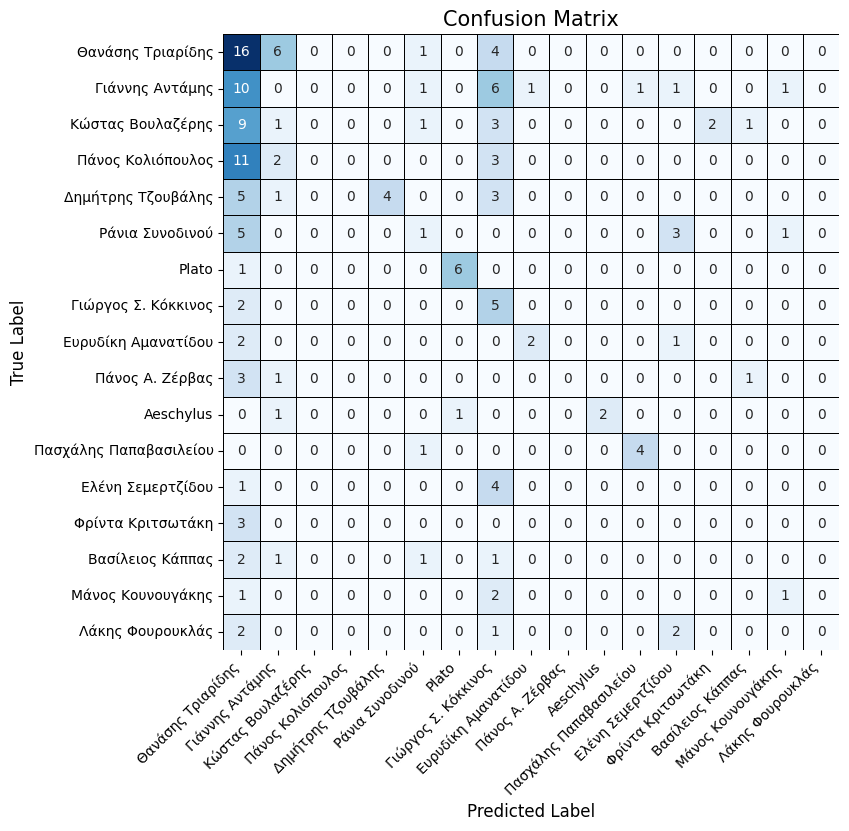

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(barzokas_pop_mini.author,
                      barzokas_pop_mini.llama.str.strip(),
                      labels=pop_authors)

# Create a custom plot with Seaborn for better aesthetics
plt.figure(figsize=(10, 8))  # Increase figure size for readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,  # Add annotations and color
            xticklabels=pop_authors, yticklabels=pop_authors,
            linewidths=0.5, linecolor='black', square=True)

# Add labels, title, and customize ticks
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=15)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Save the plot as a PDF with DPI=300
plt.savefig("confusion_matrix.pdf", format="pdf", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()

In [ ]:
barzokas_pop.to_csv('barzokas_pop_llama70b.csv')

# Raw data analysis

In [ ]:
#@title download the data
raw_data = {}
raw_data['prokopidis'] = gena.ProkopidisCrawledDt(datasets=gr_data).get('train')
raw_data['dritsa'] = gena.DritsaDt(datasets=gr_data).get('train')
raw_data['papantoniou'] = gena.PapantoniouDt(datasets=gr_data).get('train')

Title: A Greek Parliament Proceedings Dataset for Computational Linguistics and Political Analysis
Keywords: 
Publication date: 2022-06-09
DOI: 10.5281/zenodo.7005201
Total size: 1.4 GB

Link: https://zenodo.org/records/7005201/files/Greek Parliament Proceedings Dataset_Support Files_Word Usage Change Computations.zip   size: 1.4 GB

Checksum is correct. (81b2db432707334f85bd6feb44caac79)
All files have been downloaded.
Title: Dataset for Named Entity Recognition and Entity Linking from Greek Wikipedia Events
Keywords: Named Entity Recognition, Named Entity Linking, Benchmarking
Publication date: 2022-12-12
DOI: 10.5281/zenodo.7429037
Total size: 2.9 MB

Link: https://zenodo.org/records/7429037/files/ner_nel_greek_dataset.zip   size: 2.9 MB

Checksum is correct. (4dd6186f149be5b5a76336c28b88c1f1)
All files have been downloaded.


* Train a character-level language model per dataset.
* Compute the BPC per dataset.
* Draw a BPC heatmap, showing in red the dataset linguistically surprised by which.

In [ ]:
#!git clone https://github.com/ipavlopoulos/lm.git
from lm.markov.models import LM

train_sets = {}
test_sets = {}
for dataset_name in raw_data:
  print(dataset_name)
  dataset = raw_data[dataset_name]
  dataset = dataset[dataset.text.notna()]
  dataset = dataset.sample(frac=1).reset_index(drop=True)
  train_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[:1000] # lower lim
  test_sets[dataset_name] = dataset.text.apply(lambda x: x[:100]).iloc[1000:1500]

prokopidis
dritsa
papantoniou


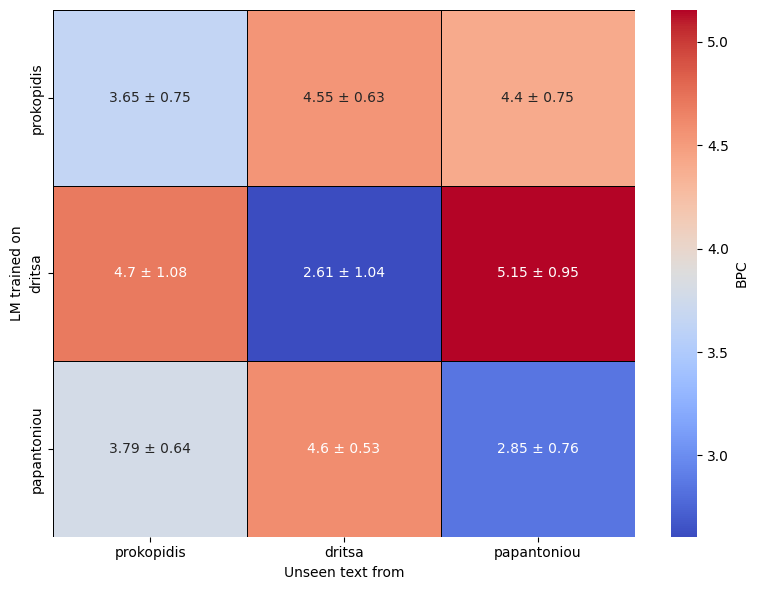

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize dictionaries to store means and standard deviations
ppls = {}
ppls_sem = {}

# Calculate means and standard deviations
for dname in raw_data:
    train = train_sets[dname]
    test = test_sets[dname]
    lm = LM(gram="CHAR")
    lm.train(' '.join(train.values)[:65000])  # length of min dataset
    ppls[dname] = {}
    ppls_sem[dname] = {}
    for dname2 in raw_data:
        scores = test_sets[dname2].apply(lm.bpc)
        ppls[dname][dname2] = scores.mean()
        ppls_sem[dname][dname2] = scores.sem()

# Convert to DataFrames
ppls_pd = pd.DataFrame(ppls)
ppls_sem_pd = pd.DataFrame(ppls_std)

# Create annotations with both mean and standard deviation
annotations = ppls_pd.round(2).astype(str) + " ± " + ppls_sem_pd.round(2).astype(str)

# Plot heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(ppls_pd, annot=annotations, fmt='', cmap=plt.cm.coolwarm, linewidths=0.5,
            linecolor='black', cbar_kws={'label': 'BPC'})

# Add labels and a title
#plt.title('BPC per LM per dataset')
plt.xlabel('Unseen text from'); plt.ylabel('LM trained on');
plt.tight_layout();
plt.savefig('ppl_heatmap.pdf', dpi=300, format='PDF')

* Counting characters

In [ ]:
tokens_num_all = 0
for dataset_name in raw_data:
  texts = raw_data[dataset_name][raw_data[dataset_name].text.notna()].text.values
  tokens_num = sum([t.strip().count(' ')+1 for t in texts])
  print(f'{dataset_name} ==> tokens: {tokens_num}')
  tokens_num_all += tokens_num

print(len(tokens_num_all))

In [ ]:
print(len(tokens_num_all))